# Tensorizing Neural Networks

This is an example of how one can tensorize layers of pre-trained neural network
models, as described in [[NPOV15']](https://arxiv.org/abs/1509.06569)

In [ ]:
%mkdir data
%mkdir models

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt

import tensorkrowch as tk

In [2]:
device = torch.device('cpu')

if torch.cuda.is_available():
    device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device('mps:0')
else:
    device = torch.device('cpu')

device

device(type='cuda', index=0)

## Dataset

In [3]:
# FashionMNIST Dataset
dataset_name = 'fashion_mnist'
batch_size = 64
image_size = 28
input_size = image_size ** 2
num_classes = 10

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(image_size, antialias=True),
                               ])

# Load data
train_dataset = datasets.FashionMNIST(root='data/',
                                      train=True,
                                      transform=transform,
                                      download=True)
test_dataset = datasets.FashionMNIST(root='data/',
                                     train=False,
                                     transform=transform,
                                     download=True)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True)

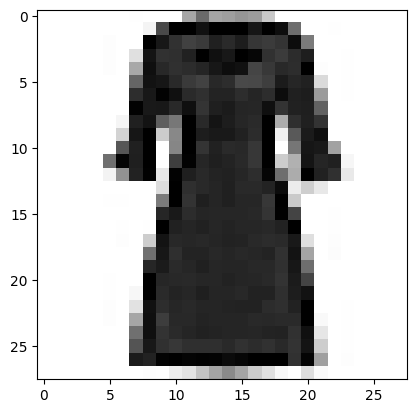

3


In [4]:
random_sample = torch.randint(low=0, high=len(train_dataset), size=(1,)).item()

plt.imshow(train_dataset[random_sample][0].squeeze(0), cmap='Greys')
plt.show()

print(train_dataset[random_sample][1])

## Train Neural Network

In [5]:
class FFFC(nn.Module):  # Feed forward fully connected
    
    def __init__(self, input_size, num_classes):
        super().__init__() # super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
# Initialize network
model_name = 'fffc'
model = FFFC(input_size=input_size, num_classes=num_classes)
model = model.to(device)

In [7]:
# Hyperparameters
learning_rate = 1e-3
weight_decay = 1e-5
num_epochs = 10

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),
                       lr=learning_rate,
                       weight_decay=weight_decay)

In [8]:
# Check accuracy on training & test to see how good our model is
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            x = x.reshape(x.shape[0], -1)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        accuracy = float(num_correct) / float(num_samples) * 100
    model.train()
    return accuracy

In [9]:
# Train network
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device)
        targets = targets.to(device)
        
        # Get to correct shape
        data = data.reshape(data.shape[0], -1)
        
        # Forward
        scores = model(data)
        loss = criterion(scores, targets)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient descent
        optimizer.step()
    
    train_acc = check_accuracy(train_loader, model)
    test_acc = check_accuracy(test_loader, model)
    
    print(f'* Epoch {epoch + 1:<3} => Train. Acc.: {train_acc:.2f},'
          f' Test Acc.: {test_acc:.2f}')

torch.save(model.state_dict(), f'models/{model_name}_{dataset_name}.pt')

* Epoch 1   => Train. Acc.: 84.52, Test Acc.: 83.08
* Epoch 2   => Train. Acc.: 86.19, Test Acc.: 84.96
* Epoch 3   => Train. Acc.: 86.57, Test Acc.: 85.15
* Epoch 4   => Train. Acc.: 87.06, Test Acc.: 85.08
* Epoch 5   => Train. Acc.: 87.96, Test Acc.: 86.15
* Epoch 6   => Train. Acc.: 87.83, Test Acc.: 86.07
* Epoch 7   => Train. Acc.: 88.56, Test Acc.: 86.62
* Epoch 8   => Train. Acc.: 89.33, Test Acc.: 86.69
* Epoch 9   => Train. Acc.: 88.94, Test Acc.: 86.45
* Epoch 10  => Train. Acc.: 89.30, Test Acc.: 87.03


In [9]:
def n_params(model):
    n = 0
    for p in model.parameters():
        n += p.numel()
    return n

In [11]:
n = n_params(model)
test_acc = check_accuracy(test_loader, model)
test_acc, n

(87.03, 39760)

## Define tensorized layer

In [10]:
# Load network
model = FFFC(input_size=input_size, num_classes=num_classes)
model.load_state_dict(torch.load(f'models/{model_name}_{dataset_name}.pt'))
model = model.to(device)

In [11]:
class TN_Linear(tk.models.MPO):
    
    def __init__(self, model, cum_percentage):
        
        # Get weight matrix from model and reshape it
        weight = model.fc1.weight.detach()
        weight = weight.reshape(1, 1, 5, 5, 2, 1,
                                2, 2, 7, 7, 2, 2).permute(6, 0, 7, 1, 8, 2,
                                                          9, 3, 10, 4, 11, 5)
        self.weight = weight
        
        mpo_tensors = tk.decompositions.mat_to_mpo(weight,
                                                   cum_percentage=cum_percentage,
                                                   renormalize=True)
        super().__init__(tensors=mpo_tensors)
        
        # Save bias as parameter of tn layer
        self.bias = nn.Parameter(model.fc1.bias.detach())
    
    def set_data_nodes(self):
        self.mps_data = tk.models.MPSData(n_features=6,
                                          phys_dim=[2, 2, 7, 7, 2, 2],
                                          bond_dim=10,
                                          boundary='obc')
    
    def add_data(self, data):
        mps_tensors = tk.decompositions.vec_to_mps(data.reshape(-1, 2, 2, 7, 7, 2, 2),
                                                   n_batches=1,
                                                   cum_percentage=0.95,
                                                   renormalize=True)
        self.mps_data.add_data(mps_tensors)
    
    def contract(self):
        return super().contract(inline_input=True,
                                inline_mats=True,
                                mps=self.mps_data)
        
    def forward(self, x, *args, **kwargs):
        result = super().forward(x, *args, **kwargs)
        result = result.reshape(-1, 50)
        result += self.bias
        return result

In [12]:
class TN_NN(nn.Module):
    def __init__(self, model, cum_percentage):
        super().__init__() # super(NN, self).__init__()
        self.tn1 = TN_Linear(model, cum_percentage)
        self.fc2 = model.fc2
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.tn1(x))
        x = self.fc2(x)
        return x

In [13]:
model_name = 'tn_fffc'
tn_model = TN_NN(model, 0.85)

In [19]:
n = n_params(tn_model)
test_acc = check_accuracy(test_loader, tn_model)
test_acc, n

(86.61999999999999, 27944)

## Train

In [14]:
# Trace the model to accelerate training
tn_model.tn1.trace(torch.zeros(1, input_size, device=device))

In [15]:
# Hyperparameters
learning_rate = 1e-4
weight_decay = 1e-5
num_epochs = 5

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(tn_model.parameters(),
                       lr=learning_rate,
                       weight_decay=weight_decay)

In [16]:
# Train network
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device)
        targets = targets.to(device)
        
        # Get to correct shape
        data = data.reshape(data.shape[0], -1)
        
        # Forward
        scores = tn_model(data)
        loss = criterion(scores, targets)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient descent
        optimizer.step()
    
    train_acc = check_accuracy(train_loader, tn_model)
    test_acc = check_accuracy(test_loader, tn_model)
    
    print(f'* Epoch {epoch + 1:<3} => Train. Acc.: {train_acc:.2f},'
          f' Test Acc.: {test_acc:.2f}')

# Reset before saving the model
tn_model.tn1.reset()
torch.save(tn_model.state_dict(), f'models/{model_name}_{dataset_name}.pt')

* Epoch 1   => Train. Acc.: 90.04, Test Acc.: 87.95
* Epoch 2   => Train. Acc.: 90.03, Test Acc.: 87.73
* Epoch 3   => Train. Acc.: 90.35, Test Acc.: 87.70
* Epoch 4   => Train. Acc.: 90.64, Test Acc.: 87.90
* Epoch 5   => Train. Acc.: 90.73, Test Acc.: 88.03


In [17]:
tn_model.tn1.canonicalize(cum_percentage=0.8)

test_acc = check_accuracy(test_loader, tn_model)
print(test_acc, n_params(tn_model))

81.57 16406
